# Data science for budiness project
This project is made by 
- Drago Emanuele
- Lambrughi Achille

The aim of this project is to retrive, clean, analyze and develop a machine learning model starting from some given dataset.

The dataset considered are available at the following link:
- https://www.dati.lombardia.it/Attivit-Produttive/Rapporti-di-lavoro-attivati/qbau-cyuc

- https://www.dati.lombardia.it/Attivit-Produttive/Rapporti-di-lavoro-cessati/nwz3-p6vm

- https://www.dati.lombardia.it/Attivit-Produttive/Rapporti-di-lavoro-prorogati/chng-cman

- https://www.dati.lombardia.it/Attivit-Produttive/Rapporti-di-lavoro-trasformati/8dwx-jjag

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl, matplotlib.pyplot as plt
from pathlib import PurePath

In [2]:
rap_lavoro_attivati = pd.read_csv(PurePath('dataset', 'Rapporti_di_lavoro_attivati.csv'),parse_dates=['DATA'])
rap_lavoro_cessati = pd.read_csv(PurePath('dataset', 'Rapporti_di_lavoro_cessati.csv'),parse_dates=['DATA'])
rap_lavoro_prorogati = pd.read_csv(PurePath('dataset', 'Rapporti_di_lavoro_prorogati.csv'),parse_dates=['DATA'])
rap_lavoro_trasformati = pd.read_csv(PurePath('dataset', 'Rapporti_di_lavoro_trasformati.csv'),parse_dates=['DATA'])
print([rap_lavoro_attivati.info(), rap_lavoro_cessati.info(),rap_lavoro_prorogati.info(),rap_lavoro_trasformati.info()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579794 entries, 0 to 9579793
Data columns (total 9 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   DATA                       datetime64[ns]
 1   GENERE                     object        
 2   ETA                        int64         
 3   SETTOREECONOMICODETTAGLIO  object        
 4   TITOLOSTUDIO               object        
 5   CONTRATTO                  object        
 6   MODALITALAVORO             object        
 7   PROVINCIAIMPRESA           object        
 8   ITALIANO                   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 657.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741394 entries, 0 to 3741393
Data columns (total 9 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   DATA                       object
 1   GENERE                     object
 2   ETA                        

In [3]:
def series_to_set(column, source_df):
    SET = set()
    for elem in source_df[column]:
        SET.add(elem)
    return SET

test_dataset = series_to_set('MODALITALAVORO', rap_lavoro_attivati)
test_dataset

{'NON DEFINITO',
 'TEMPO PARZIALE MISTO',
 'TEMPO PARZIALE ORIZZONTALE',
 'TEMPO PARZIALE VERTICALE',
 'TEMPO PIENO',
 nan}

# Dataset analysis
In this section will be analyzed the content of the datasets. The first group of datasets contain work relations started\ended\changed\extended. Calling the `info()` method is possible to see that all dataset share the same columns that are:
- DATA: date of the contract
- GENERE: sex of teh person
- ETA: age of the person
- SETTOREECONOMICODETTAGLIO: category of work
- TITOLOSTUDIO: level of education of the person
- CONTRATTO: type of contract
- MODALITALAVORO: work mode
- PROVINCIAIMPRESA: province of the place of work?
- ITALIANO: nationality of the person

From this first look at the data is possible to see that the dataset `Rapporti_di_lavoro_attivati` is bigger than the other one and this can itroduce some sort of bias in specific type of analysis

### Changing data type
Almost all columns of the dataset are type object, in the following part we will convert every column in an appropriate type.

Starting from the column `DATA` that has been converted whilie importing the data from the csv a part for `Rapporti_di_lavoro_cessati.csv` that has not been converted and so it will be converted now.
Then all the other column except for `ETA` will be converted to strings

In [4]:
rap_lavoro_cessati['DATA'] = pd.to_datetime(rap_lavoro_cessati['DATA'], errors='coerce')
rap_lavoro_attivati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']]=rap_lavoro_attivati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']].astype('string')
rap_lavoro_cessati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']]=rap_lavoro_cessati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']].astype('string')
rap_lavoro_trasformati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']]=rap_lavoro_trasformati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']].astype('string')
rap_lavoro_prorogati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']]=rap_lavoro_prorogati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']].astype('string')

as is possible to see now all the column have a specific data type

In [5]:
rap_lavoro_attivati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579794 entries, 0 to 9579793
Data columns (total 9 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   DATA                       datetime64[ns]
 1   GENERE                     string        
 2   ETA                        int64         
 3   SETTOREECONOMICODETTAGLIO  string        
 4   TITOLOSTUDIO               string        
 5   CONTRATTO                  string        
 6   MODALITALAVORO             string        
 7   PROVINCIAIMPRESA           string        
 8   ITALIANO                   string        
dtypes: datetime64[ns](1), int64(1), string(7)
memory usage: 657.8 MB


### Searching wrong and null data
Now we will look inside the data checking null or possibly wrong value, after those data will be corrected or deleted.
First off we will find out how many null value there are in each column

In [6]:
print([rap_lavoro_attivati.isnull().sum(),rap_lavoro_cessati.isnull().sum(),rap_lavoro_prorogati.isnull().sum(),rap_lavoro_trasformati.isnull().sum()])

[DATA                              0
GENERE                            0
ETA                               0
SETTOREECONOMICODETTAGLIO      2888
TITOLOSTUDIO                    580
CONTRATTO                         0
MODALITALAVORO               440779
PROVINCIAIMPRESA                  0
ITALIANO                          0
dtype: int64, DATA                            1
GENERE                          0
ETA                             0
SETTOREECONOMICODETTAGLIO    1019
TITOLOSTUDIO                  440
CONTRATTO                       0
MODALITALAVORO                  0
PROVINCIAIMPRESA                0
ITALIANO                        0
dtype: int64, DATA                            0
GENERE                          0
ETA                             0
SETTOREECONOMICODETTAGLIO    2291
TITOLOSTUDIO                  160
CONTRATTO                       0
MODALITALAVORO                  0
PROVINCIAIMPRESA                0
ITALIANO                        0
dtype: int64, DATA                 

From this first look is possible to see that a big part of value is missing from the column `MODALITALAVORO` of the dataset `Rapporti_di_lavoro_attivati` these value needs to be replaced while the other could be simply deleted because they represent a small part of the dataset.

But before proceding now will be checked the actual value of some columnn to see if there are some non plausible data.
Starting from the column `DATA`

In [7]:
rap_lavoro_attivati['DATA'].describe(datetime_is_numeric=True)

count                          9579794
mean     2015-08-22 08:39:17.195402496
min                1973-02-01 00:00:00
25%                2012-06-07 00:00:00
50%                2015-10-08 00:00:00
75%                2018-09-07 00:00:00
max                2201-06-09 00:00:00
Name: DATA, dtype: object

In [8]:
rap_lavoro_attivati = rap_lavoro_attivati[rap_lavoro_attivati['DATA'] < np.datetime64('2022-02-20')]

In [9]:
rap_lavoro_attivati['DATA'].describe(datetime_is_numeric=True)

count                          9579793
mean     2015-08-22 08:29:05.161381888
min                1973-02-01 00:00:00
25%                2012-06-07 00:00:00
50%                2015-10-08 00:00:00
75%                2018-09-07 00:00:00
max                2021-10-06 00:00:00
Name: DATA, dtype: object

In [10]:
rap_lavoro_attivati['DATA'].max

<bound method NDFrame._add_numeric_operations.<locals>.max of 0         2020-09-05
1         2019-12-07
2         2013-05-06
3         2010-12-03
4         2021-06-04
             ...    
9579789   2020-01-03
9579790   2010-06-09
9579791   2021-06-11
9579792   2010-02-02
9579793   2012-05-07
Name: DATA, Length: 9579793, dtype: datetime64[ns]>

In [11]:
settore_economico = series_to_set('SETTOREECONOMICODETTAGLIO', rap_lavoro_attivati)
len(settore_economico)

1225

Since the `SETTOREECONOMICODETTAGLIO` column has `1125` different values belonging to it, it cannot be easily exploited to analyze data (e.g. dividing them into categories). Furthermore, there are `2888` null values in this column that can make the analysis of this feature even tougher. Considering this two facts, we can derive that dropping the whole column is more convenient than keeping it, since it introduce noise. 

In [12]:
rap_lavoro_attivati.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,2020-09-05,F,60,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA
1,2019-12-07,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
2,2013-05-06,F,20,Fabbricazione di altre apparecchiature elettri...,LICENZA MEDIA,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,2010-12-03,F,28,Alberghi,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERMITTENTE A TEMPO DETERMINATO,NON DEFINITO,BERGAMO,ITALIA
4,2021-06-04,F,49,Rifugi di montagna,LICENZA MEDIA,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA


In the `rap_lavoro_attivati` there are a lot of null values for the column `MODALITALAVORO`, removing the rows would reduce the set of data we are analysing. Hence, we'd rather prefer to fill those null values with a suitable values. 

In [13]:
mod_lavoro = series_to_set('MODALITALAVORO', rap_lavoro_attivati)
mod_lavoro

{<NA>,
 'NON DEFINITO',
 'TEMPO PARZIALE MISTO',
 'TEMPO PARZIALE ORIZZONTALE',
 'TEMPO PARZIALE VERTICALE',
 'TEMPO PIENO'}

The value `NON DEFINITO` can be used to fill the na, since that won't introduce much bias, differently from the other available values. 

In [14]:
def clean(df):
    df.drop('SETTOREECONOMICODETTAGLIO', axis = 1, inplace = True)
    df['MODALITALAVORO'] = df['MODALITALAVORO'].fillna('NON DEFINITO')
    df.dropna(axis = 0, inplace = True)
    

clean(rap_lavoro_attivati)
rap_lavoro_attivati.isnull().sum()

DATA                0
GENERE              0
ETA                 0
TITOLOSTUDIO        0
CONTRATTO           0
MODALITALAVORO      0
PROVINCIAIMPRESA    0
ITALIANO            0
dtype: int64

A similar analysis can be made with the other three Dataframes `rap_lavoro_cessati`, `rap_lavoro_prorogati` and `rap_lavoro_trasformati`

In [15]:
clean(rap_lavoro_cessati)
clean(rap_lavoro_prorogati)
clean(rap_lavoro_trasformati)

#### Working on column `DATA`
In this section we will analyze in more detail the column `DATA` and adjust the data accordingly.
The first step is to group the column by year and count how many contract are activated per year

In [16]:
print(rap_lavoro_attivati.groupby(pd.Grouper(key='DATA', freq='Y'))['DATA'].count())

DATA
1973-12-31         1
1974-12-31         1
1975-12-31         0
1976-12-31         1
1977-12-31         0
1978-12-31         2
1979-12-31         1
1980-12-31         1
1981-12-31         1
1982-12-31         1
1983-12-31         0
1984-12-31         0
1985-12-31         0
1986-12-31         0
1987-12-31         0
1988-12-31         1
1989-12-31         0
1990-12-31         0
1991-12-31         0
1992-12-31         0
1993-12-31         0
1994-12-31         0
1995-12-31         0
1996-12-31         1
1997-12-31         2
1998-12-31         0
1999-12-31         1
2000-12-31         0
2001-12-31        38
2002-12-31         0
2003-12-31         2
2004-12-31         2
2005-12-31         1
2006-12-31         3
2007-12-31         6
2008-12-31      1590
2009-12-31    397351
2010-12-31    792751
2011-12-31    858670
2012-12-31    763733
2013-12-31    673152
2014-12-31    689300
2015-12-31    757895
2016-12-31    761881
2017-12-31    847079
2018-12-31    899082
2019-12-31    874079
2020-12-

as is possible to see meany of the value have date between 2009 and 2022, so to have a more significant set of data we will remove all the row with date previous to 2009

In [17]:
attivatiTemp = rap_lavoro_attivati[(rap_lavoro_attivati["DATA"] >= '2009')]

In [18]:
print(attivatiTemp.groupby(pd.Grouper(key='DATA', freq='Y'))['DATA'].count())

DATA
2009-12-31    397351
2010-12-31    792751
2011-12-31    858670
2012-12-31    763733
2013-12-31    673152
2014-12-31    689300
2015-12-31    757895
2016-12-31    761881
2017-12-31    847079
2018-12-31    899082
2019-12-31    874079
2020-12-31    640133
2021-12-31    622451
Freq: A-DEC, Name: DATA, dtype: int64


With this we can see how many contract have been activated in the last few years in the Lombardy region. But before that we apply the same changes to the other datast and after that we can compare the result

In [19]:
cessatiTemp = rap_lavoro_cessati[(rap_lavoro_cessati["DATA"] >= '2009')]
trasformatiTemp = rap_lavoro_trasformati[(rap_lavoro_trasformati["DATA"] >= '2009')]
prorogatiTemp = rap_lavoro_prorogati[(rap_lavoro_prorogati["DATA"] >= '2009')]

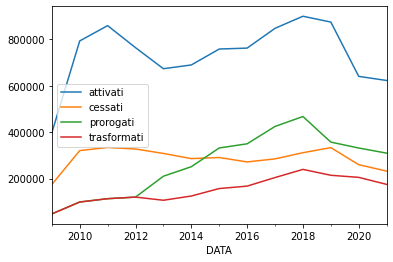

In [20]:
attivatiTemp.groupby(pd.Grouper(key='DATA', freq='Y'))['DATA'].count().plot(label="attivati")
cessatiTemp.groupby(pd.Grouper(key='DATA', freq='Y'))['DATA'].count().plot(label="cessati")
prorogatiTemp.groupby(pd.Grouper(key='DATA', freq='Y'))['DATA'].count().plot(label="prorogati")
trasformatiTemp.groupby(pd.Grouper(key='DATA', freq='Y'))['DATA'].count().plot(label="trasformati")
plt.legend()
plt.show()

is possible to see that *attivati* and *cessati*  have a simila behavior but in a different scale while *trasformati* and *prorogati* differs from the previous but have some similarity between them.

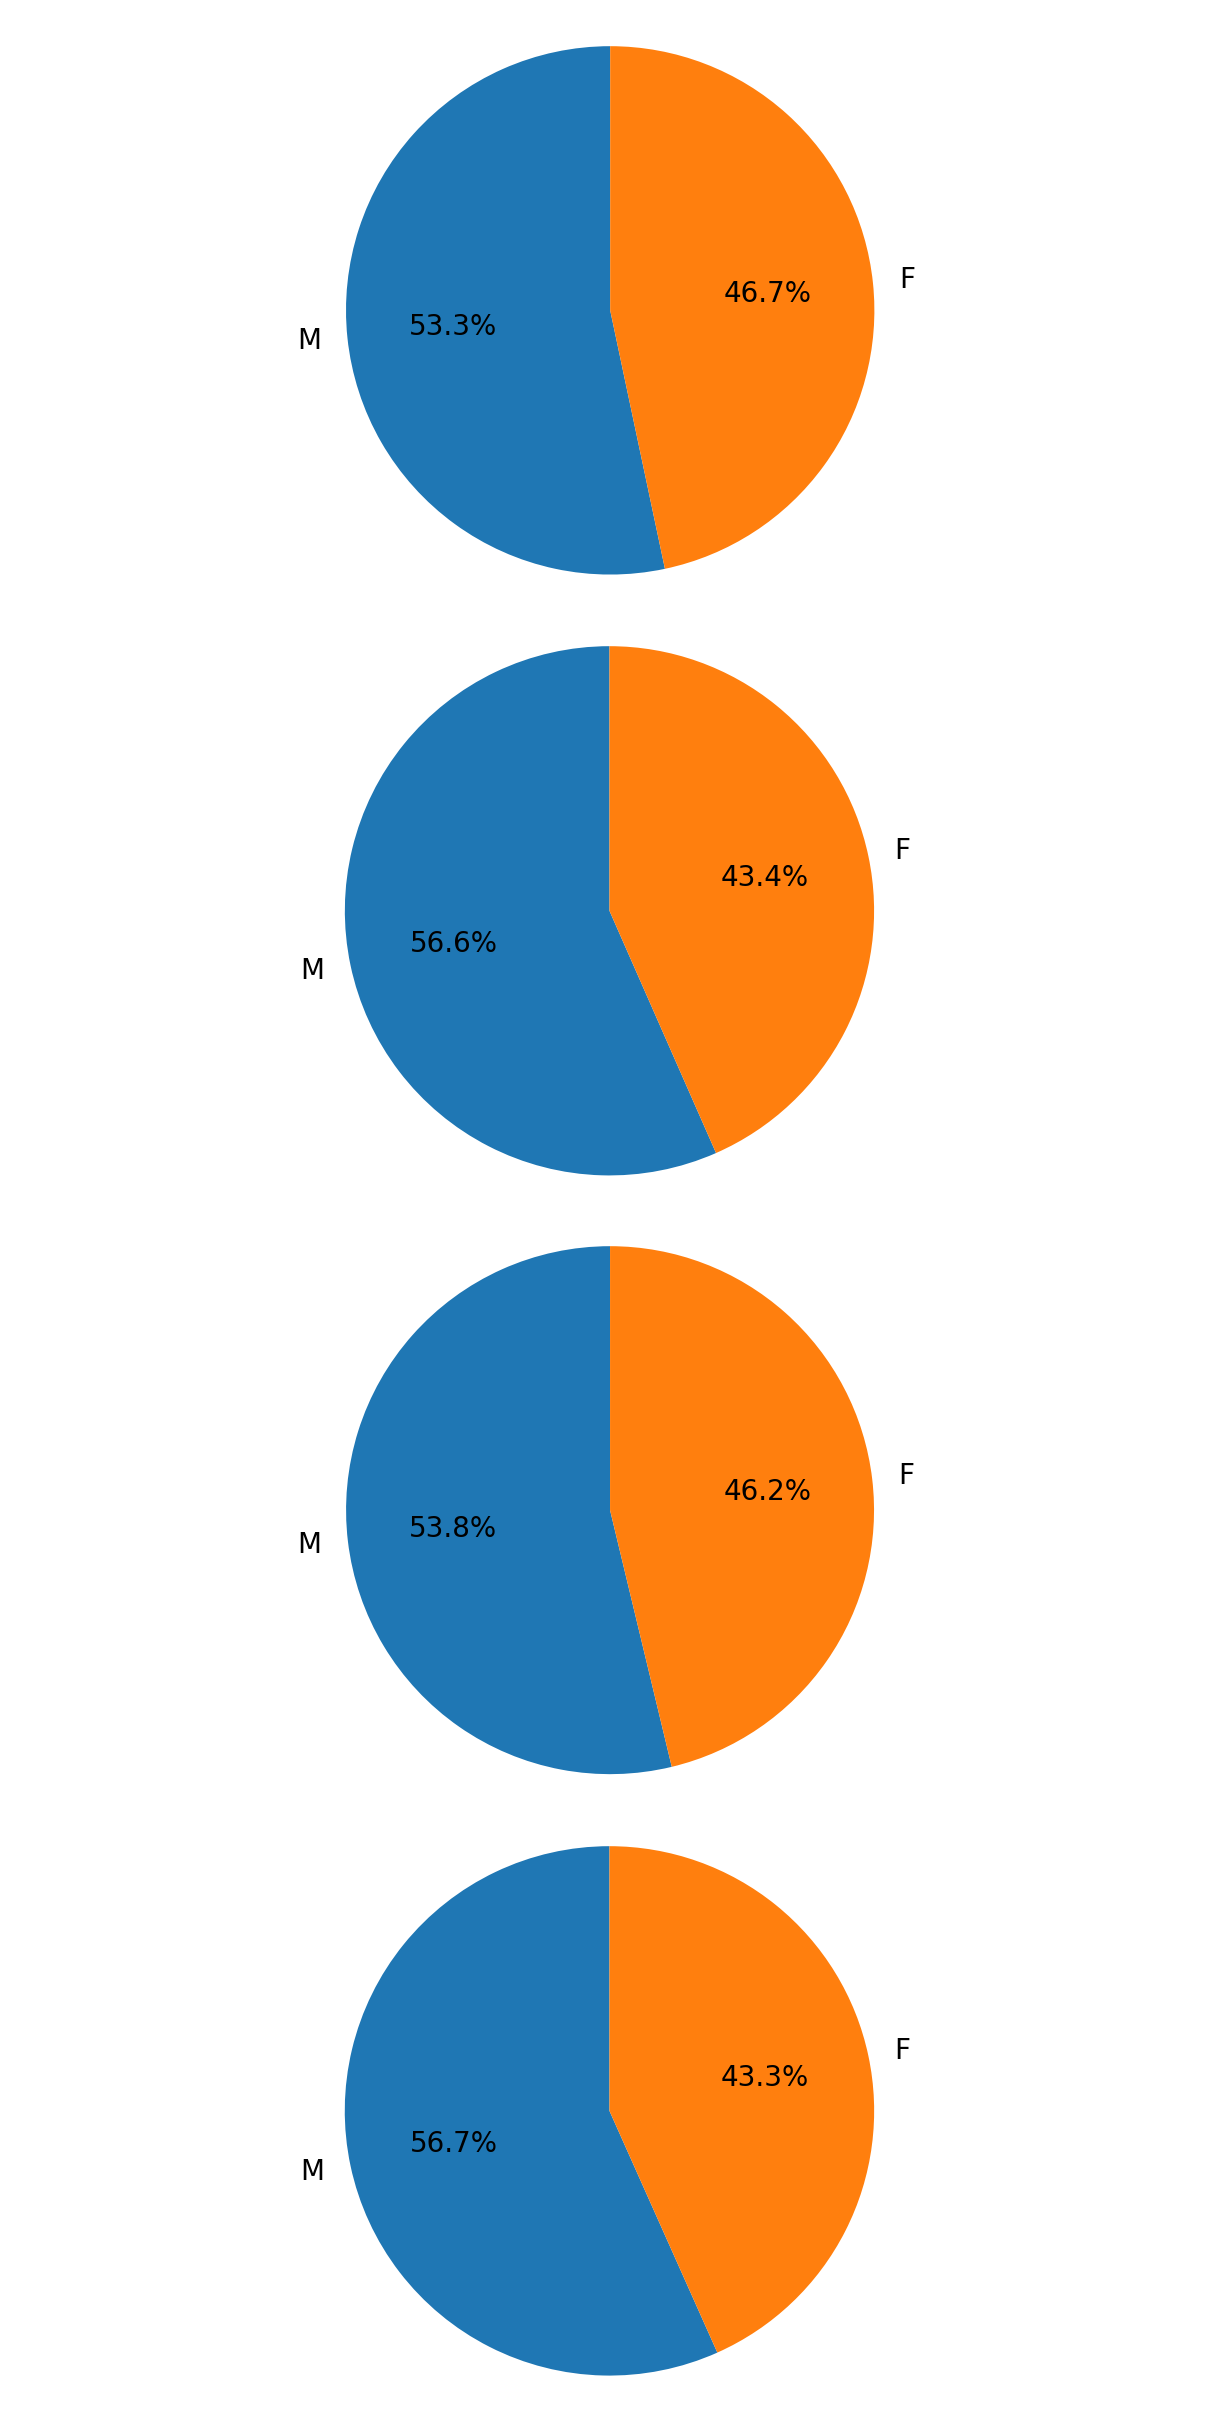

In [21]:
m_to_f_rationA = rap_lavoro_attivati.GENERE.value_counts()
m_to_f_rationC = rap_lavoro_cessati.GENERE.value_counts()
m_to_f_rationT = rap_lavoro_trasformati.GENERE.value_counts()
m_to_f_rationP = rap_lavoro_prorogati.GENERE.value_counts()

xaxisA = m_to_f_rationA.index
valueA = m_to_f_rationA.values

xaxisC = m_to_f_rationC.index
valueC = m_to_f_rationC.values

xaxisT = m_to_f_rationT.index
valueT = m_to_f_rationT.values

xaxisP = m_to_f_rationP.index
valueP = m_to_f_rationP.values


fig1, axis = plt.subplots(4, constrained_layout=True)
fig1.dpi = 200
fig1.set_figheight(12)

#Attivati male to female Graph
axis[0].pie(valueA, labels=xaxisA, autopct='%1.1f%%', startangle=90)
axis[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#Cessati graph
axis[1].pie(valueC, labels=xaxisC, autopct='%1.1f%%', startangle=90)
axis[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#Trasformati graph
axis[2].pie(valueT, labels=xaxisT, autopct='%1.1f%%', startangle=90)
axis[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#Proprogati graph
axis[3].pie(valueP, labels=xaxisP, autopct='%1.1f%%', startangle=90)
axis[3].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

from these graphs we can say that probably there are more male than female in the popoulation